# 变分量子因子分解

## 项目介绍

[Variational Quantum Factoring](https://arxiv.org/abs/1808.08927)

文章提出的VQF方案能对数进行因子分解，利用MindQuantum部分复现论文中提到的算法，并给出35、56153和291311的分解结果。

## 算法原理

### Variational Quantum Factoring(VQF)

变分量子因子分解，对于m=p*q(p≥q)，m、p、q均用二进制表示，则整个乘法过程可分解个$n_c$个恒等于0的子句(clause)$C_i$，

令$H=\sum C_i^2$便可将其转换为最小值优化问题。

### VQF Clauses

VQF的子句可以有各种形式，此处设计VQFClauses希望能适应任意形式的VQF子句。

## 复现过程

[src目录参考](https://gitee.com/mindspore/mindquantum/tree/research/paper_recurrence/2023/40_hw58695368/src)

In [1]:
# pylint: disable=W0611
from src.vqf_clauses_lib import VQFClausesA        # VQF子句集-A型
from src.vqf_preprocessor import VQFPreprocessor   # VQF预处理器（未完成）
from src.qaoa_ansatz import QAOAAnsatz             # QAOA

from sympy import Symbol
import mindspore as ms
import mindspore.nn as nn
from mindquantum.framework import MQAnsatzOnlyLayer
from mindquantum.simulator import Simulator

ms.set_context(mode=ms.PYNATIVE_MODE, device_target="CPU")

[WARNING] ME(146144:140517117358912,MainProcess):2023-10-18-00:21:34.169.649 [mindspore/run_check/_check_version.py:102] MindSpore version 2.1.0 and cuda version 11.2.72 does not match, CUDA version [['10.1', '11.1', '11.6']] are supported by MindSpore officially. Please refer to the installation guide for version matching information: https://www.mindspore.cn/install.


### 1.分解56153

#### 1.1.生成子句集并假装执行预处理

In [2]:
m, p, q = 56153, 241, 233     # 问题
vc = VQFClausesA(m, [p, q])   # 子句集
vpp = VQFPreprocessor()       # 预处理器
vpp.cheat(vc)                 # 采用cheat方法预处理子句集

#### 1.2.生成量子线路与哈密顿量

In [3]:
depth = 4                                     # QAOA线路深度
ham, var_list = vc.get_ham(0, vc.n_clauses)   # 获取哈密顿量和对应变量列表
qaoa = QAOAAnsatz(ham, depth)                 # 根据哈密顿量生成QAOA
circ = qaoa.circuit                           # QAOA线路
ham = qaoa.hamiltonian                        # QAOA哈密顿量

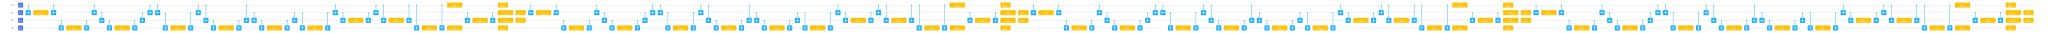

In [4]:
circ.svg()

#### 1.3.优化

In [5]:
sim = Simulator('mqvector', circ.n_qubits)                     # 创建模拟器，backend使用‘mqvector’，能模拟5个比特（'circ'线路中包含的比特数）
grad_ops = sim.get_expectation_with_grad(ham, circ)            # 获取计算变分量子线路的期望值和梯度的算子
net = MQAnsatzOnlyLayer(grad_ops)                              # 生成待训练的神经网络
opti = nn.Adam(net.trainable_params(), learning_rate=0.05)     # 设置针对网络中所有可训练参数、学习率为0.05的Adam优化器
train_net = nn.TrainOneStepCell(net, opti)                     # 对神经网络进行一步训练

In [6]:
for i in range(100):
    v = train_net()       # 将神经网络训练一步并计算得到的结果。注意：每当'train_net()'运行一次，神经网络就训练了一步
    if i%10 == 0:
        print("train step:", i, ", E:", v)  # 每训练10步，打印当前训练步数和当前得到的期望值

train step: 0 , E: [1.6245825]
train step: 10 , E: [0.49399]
train step: 20 , E: [0.39551422]
train step: 30 , E: [0.24152601]
train step: 40 , E: [0.0515389]
train step: 50 , E: [0.03572284]
train step: 60 , E: [0.01900625]
train step: 70 , E: [0.01143039]
train step: 80 , E: [0.00773408]
train step: 90 , E: [0.00489562]


获取线路参数

In [7]:
pr = dict(zip(circ.params_name, net.weight.asnumpy()))
print(pr)

{'beta_0': 0.49435595, 'alpha_0': -1.0562739, 'beta_1': 1.0758823, 'alpha_1': -0.88753265, 'beta_2': 1.3306177, 'alpha_2': -0.74297094, 'beta_3': 1.2554127, 'alpha_3': -0.37126884}


#### 1.4.处理结果

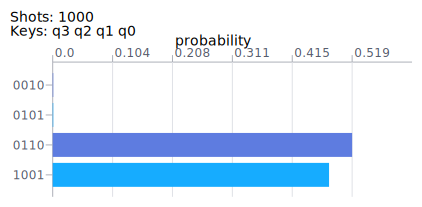

In [8]:
# pylint: disable=W0104
circ.measure_all()                               # 为线路中所有比特添加测量门
sim.sampling(circ, pr=pr, shots=1000).svg()      # 运行线路1000次并打印结果

In [9]:
res = [[0, 1, 0, 1], [1, 0, 1, 0]]   # 运行结果

查看变量列表，对应[Z0, Z1, Z2, Z3]

In [10]:
var_list

['q3', 'p3', 'q4', 'p4']

根据量子线路运行结果获取最终结果

In [11]:
for i in range(2):
    print('Case:', res[i])
    for j in range(4):
        vc.update_var(var_list[j], 0, res[i][j])  # 更新变量为常值
    print(vc.get_result())  # 获取结果

Case: [0, 1, 0, 1]
{'status': True, 'p': 249, 'q': 225, 'm': 56153, 'p_q_real': [241, 233]}
Case: [1, 0, 1, 0]
{'status': True, 'p': 225, 'q': 249, 'm': 56153, 'p_q_real': [241, 233]}


### 2.同样的过程处理291311

In [12]:
m, p, q = 291311, 557, 523
vc = VQFClausesA(m, [p, q])
vpp = VQFPreprocessor()
vpp.cheat(vc)
for i in range(vc.n_clauses):
    print(vc.get_expr(i))  # 子句表达式 (表达式，变量列表)

('(p1)+(q1)+(-1)', ['p1', 'q1'])
('(p2)+(q2)+(-1)', ['q2', 'p2'])
('(p5)+(q5)+(-1)', ['q5', 'p5'])
('(p1)*(q2)+(p2)*(q1)+(-1)', ['p1', 'q1', 'p2', 'q2'])
('(p2)*(q5)+(p5)*(q2)+(0)', ['q2', 'q5', 'p2', 'p5'])
('(p1)*(q5)+(p5)*(q1)+(-1)', ['p1', 'q5', 'p5', 'q1'])


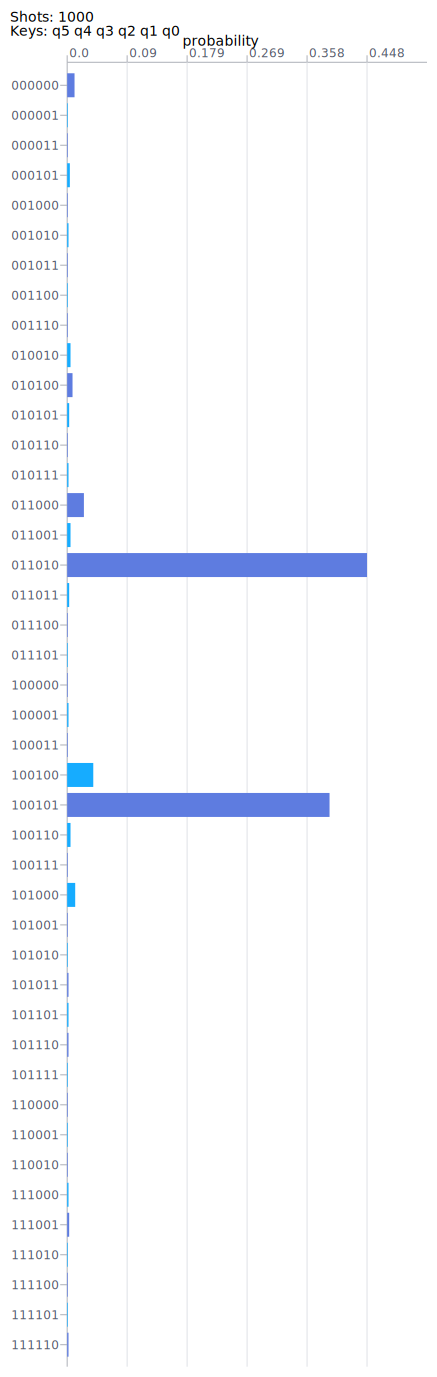

In [13]:
depth = 4
ham, var_list = vc.get_ham(0, vc.n_clauses)
qaoa = QAOAAnsatz(ham, depth)
circ = qaoa.circuit
ham = qaoa.hamiltonian
sim = Simulator('mqvector', circ.n_qubits)                     # 创建模拟器，backend使用‘mqvector’，能模拟5个比特（'circ'线路中包含的比特数）
grad_ops = sim.get_expectation_with_grad(ham, circ)            # 获取计算变分量子线路的期望值和梯度的算子
net = MQAnsatzOnlyLayer(grad_ops)                              # 生成待训练的神经网络
opti = nn.Adam(net.trainable_params(), learning_rate=0.05)     # 设置针对网络中所有可训练参数、学习率为0.05的Adam优化器
train_net = nn.TrainOneStepCell(net, opti)                     # 对神经网络进行一步训练
_ = [train_net() for i in range(100)]
pr = dict(zip(circ.params_name, net.weight.asnumpy()))         # 获取线路参数
circ.measure_all()
res = sim.sampling(circ, pr=pr, shots=1000)
res.svg()

In [14]:
res = [int(i) for i in max(res.data, key=lambda k: res.data[k])][::-1]
res

[0, 1, 0, 1, 1, 0]

In [15]:
print('Case:', res)
for i in range(len(var_list)):
    vc.update_var(var_list[i], 0, res[i])
print(vc.get_result())

Case: [0, 1, 0, 1, 1, 0]
{'status': True, 'p': 523, 'q': 557, 'm': 291311, 'p_q_real': [557, 523]}


### 3.无预处理分解35

#### 3.1.无预处理分解35

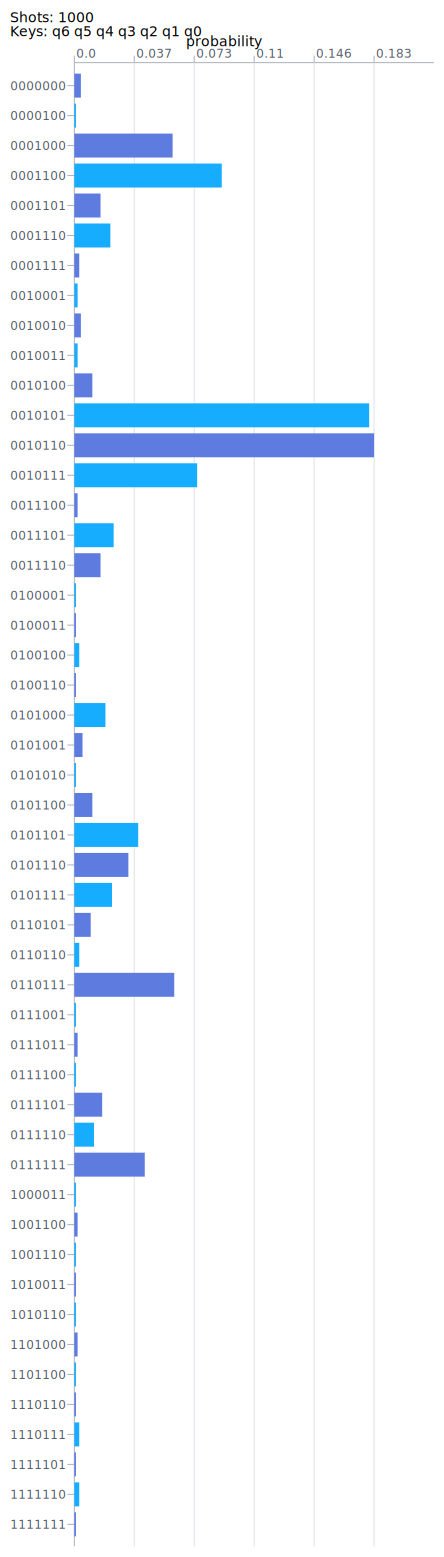

In [16]:
m, p, q = 35, 5, 7
vc = VQFClausesA(m, [p, q])
depth = 4
ham, var_list = vc.get_ham(0, vc.n_clauses)
qaoa = QAOAAnsatz(ham, depth)
circ = qaoa.circuit
ham = qaoa.hamiltonian
sim = Simulator('mqvector', circ.n_qubits)                     # 创建模拟器，backend使用‘mqvector’，能模拟5个比特（'circ'线路中包含的比特数）
grad_ops = sim.get_expectation_with_grad(ham, circ)            # 获取计算变分量子线路的期望值和梯度的算子
net = MQAnsatzOnlyLayer(grad_ops)                              # 生成待训练的神经网络
opti = nn.Adam(net.trainable_params(), learning_rate=0.05)     # 设置针对网络中所有可训练参数、学习率为0.05的Adam优化器
train_net = nn.TrainOneStepCell(net, opti)                     # 对神经网络进行一步训练
_ = [train_net() for i in range(100)]
pr = dict(zip(circ.params_name, net.weight.asnumpy()))         # 获取线路参数
circ.measure_all()
res = sim.sampling(circ, pr=pr, shots=1000)
res.svg()

In [17]:
res = [int(i) for i in max(res.data, key=lambda k: res.data[k])][::-1]
print('Case:', res)
for i in range(len(var_list)):
    vc.update_var(var_list[i], 0, res[i])
print(vc.get_result())

Case: [0, 1, 1, 0, 1, 0, 0]
{'status': True, 'p': 7, 'q': 5, 'm': 35, 'p_q_real': [5, 7]}


可以看到，结果有问题！

#### 3.2.查漏补缺

检查子句表达式

In [18]:
vc = VQFClausesA(m, [p, q])
for i in range(vc.n_clauses):
    print(vc.get_expr(i))

('(1)*(1)+(-1)', [])
('(1)*(q1)+(p1)*(1)+(-1)+(-2)*(z_1_2)', ['q1', 'p1', 'z_1_2'])
('(1)*(1)+(p1)*(q1)+(1)*(1)+(z_1_2)+(0)+(-2)*(z_2_3)+(-4)*(z_2_4)', ['q1', 'z_2_3', 'p1', 'z_1_2', 'z_2_4'])
('(p1)*(1)+(1)*(q1)+(z_2_3)+(0)+(-2)*(z_3_4)', ['p1', 'z_3_4', 'q1', 'z_2_3'])
('(1)*(1)+(z_2_4)+(z_3_4)+(0)+(-2)*(z_4_5)', ['z_3_4', 'z_4_5', 'z_2_4'])
('(z_4_5)+(-1)', ['z_4_5'])


检查每句子句的哈密顿量

In [19]:
for i in range(vc.n_clauses):
    print(vc.get_ham(i, i+1))

(0, [])
(5/2 [] +
1/2 [Z0 Z1] +
 -1 [Z0 Z2] +
 -1 [Z0] +
 -1 [Z1 Z2] +
 -1 [Z1] +
  2 [Z2], ['q1', 'p1', 'z_1_2'])
(11/2 [] +
 1/4 [Z0 Z1 Z2] +
-1/2 [Z0 Z1 Z3] +
  -1 [Z0 Z1 Z4] +
 1/4 [Z1 Z2] +
-1/2 [Z1 Z3] +
  -1 [Z1 Z4] +
 1/4 [Z0 Z2] +
-1/2 [Z0 Z3] +
  -1 [Z0 Z4] +
-1/4 [Z2] +
 1/2 [Z3] +
   1 [Z4] +
  -1 [Z2 Z3] +
  -2 [Z2 Z4] +
   4 [Z3 Z4], ['q1', 'p1', 'z_1_2', 'z_2_3', 'z_2_4'])
(  2 [] +
1/2 [Z1] +
1/2 [Z0 Z1] +
1/2 [Z1 Z2] +
 -1 [Z1 Z3] +
1/2 [Z0] +
1/2 [Z2] +
 -1 [Z3] +
1/2 [Z0 Z2] +
 -1 [Z0 Z3] +
 -1 [Z2 Z3], ['q1', 'p1', 'z_2_3', 'z_3_4'])
(5/2 [] +
  1 [Z0] +
1/2 [Z0 Z1] +
 -1 [Z0 Z2] +
  1 [Z1] +
 -2 [Z2] +
 -1 [Z1 Z2], ['z_2_4', 'z_3_4', 'z_4_5'])
( 1/2 [] +
-1/2 [Z0], ['z_4_5'])


检查所有子句的哈密顿量

In [20]:
ham, var_list = vc.get_ham(0, vc.n_clauses)
dd = [1, -1, -1, 1, -1, 1, 1]
ans = 0
ht = ham.terms
for z in ht.keys():
    item = 1
    for zz in z:
        item *= dd[zz[0]]
    ans += ht[z] * item
ans

ParameterResolver(dtype: float64, const: 0.000000)

似乎并无问题，猜测进位太多导致结果未收敛，还是得预处理一下

#### 3.4.预处理演示

由于 VQFPreprocessor 这块还未完成，所以人工预处理意思一下

这里参考 [mstechly/vqf](https://github.com/mstechly/vqf) 开源的项目采用Symbol库进行处理

In [21]:
m, p, q = 35, 5, 7
vc = VQFClausesA(m, [p, q])

In [22]:
# pylint: disable=W0122
for v in vc.all_variables:
    exec(f"{v}=Symbol('{v}')")

In [23]:
# pylint: disable=W0123
for i in range(vc.n_clauses):
    expr, vl = vc.get_expr(i)
    if vl:
        print(eval(expr))

p1 + q1 - 2*z_1_2 - 1
p1*q1 + z_1_2 - 2*z_2_3 - 4*z_2_4 + 2
p1 + q1 + z_2_3 - 2*z_3_4
z_2_4 + z_3_4 - 2*z_4_5 + 1
z_4_5 - 1


容易看出:

z_4_5=1

z_3_4=1-z_2_4

z_1_2=0

q1=1-p1

根据预处理规则对参数进行更新

In [24]:
# pylint: disable=W0123
vc.update_var('z_4_5', 0, 1)
vc.update_var('z_3_4', 2, 'z_2_4')
vc.update_var('z_1_2', 0, 0)
vc.update_var('q1', 2, 'p1')
for i in range(vc.n_clauses):
    expr, vl = vc.get_expr(i)
    if vl:
        print(eval(expr))

0
p1*(1 - p1) - 2*z_2_3 - 4*z_2_4 + 2
z_2_3 + 2*z_2_4 - 1
0


其中，p1*(1 - p1) = 0

又容易看出:

z_2_4=0

z_2_3=1

In [25]:
# pylint: disable=W0123
vc.update_var('z_2_4', 0, 0)
vc.update_var('z_2_3', 0, 1)
for i in range(vc.n_clauses):
    expr, vl = vc.get_expr(i)
    if vl:
        print(eval(expr))

0
p1*(1 - p1)
0


In [26]:
if len(vc.all_variables) == 1: # 只剩下一个变量了，随机赋个1吧
    vc.update_var(*vc.all_variables, 0, 1)
vc.get_result()

{'status': True, 'p': 7, 'q': 5, 'm': 35, 'p_q_real': [5, 7]}

## 项目总结

### 未来可继续研究的方向

① 经典代数预处理待补全

② 认为QAOA有可能能够参与子句的预处理过程

In [27]:
help(VQFPreprocessor.sliding_qaoa)

Help on function sliding_qaoa in module src.vqf_preprocessor:

sliding_qaoa(self, vc, n, th)
    Simplify clauses with sliding QAOA.
    假设与子句c相邻的n句子句的变量关联度大于n以外的非相邻子句，
    采用QAOA对该2n+1句子句进行优化，
    对最终态进行(Z_i、Z_iZ_j)测量，
    对概率大于th的结果可以有(0、1、y=x、y=1-x)等确定值或关系式。



In [29]:
from mindquantum.utils.show_info import InfoTable

InfoTable('mindquantum')

Software,Version
mindquantum,0.9.0
System,Info
Python,3.9.7
OS,Linux x86_64
Memory,16.71 GB
CPU Max Thread,8
Date,Wed Oct 18 00:23:50 2023
